In [1]:
import numpy as np
import pandas as pd
from random import shuffle

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## Helper Functions
### Read Data

In [3]:
def read_bank_note(test=False, data_frame=False):
    colnames=['variance', 'skewness', 'curtosis', 'entropy', 'y']
    if test:
        data = pd.read_csv('../data/bank-note/test.csv', header=None, names=colnames)
    else:
        data = pd.read_csv('../data/bank-note/train.csv', header=None, names=colnames)
    data['y'] = data['y'].apply(lambda x: -1 if x<1 else 1)
    if data_frame:
        return data
    else:
        X = data.drop('y', axis=1).values
        y = data['y'].values
        return X, y

### Perceptron functions

In [4]:
def add_bias(X):
    bias = np.ones(X.shape[0]).reshape(-1, 1)
    X_fit = X.copy()
    X_fit = np.concatenate([bias, X_fit], axis=1)
    return X_fit

In [5]:
def pos_neg(x):
    return 1 if x > 0 else -1

In [6]:
def get_sign(y):
    return np.array(list(map(pos_neg, y)))

In [7]:
def get_accuracy(y_pred, y):
    return (y_pred == y).sum() / len(y)

In [8]:
def get_error(y_pred, y):
    return (y_pred != y).sum() / len(y)

## Get Data

In [9]:
X_train, y_train = read_bank_note(test=False)
X_test, y_test = read_bank_note(test=True)

## Standard

In [10]:
def fit_standard(X, y, T, lr):
    
    # unpack X dimensions
    N, D = X.shape
    
    # initialize weight to zeros
    w = np.zeros(D)
    
    # get range of indicies
    idx_order = np.arange(N)
    
    # loop for number of epochs T
    for i in range(T):
        
        # shuffle data
        shuffle(idx_order)
        X = X[idx_order]
        y = y[idx_order]
        
        # loop over each row b
        for b in range(N):

            # get current X and y
            xi = X[b]
            yi = y[b]

            # multiply prediction by label
            pred = yi * w.T.dot(xi)

            # if misclassified update weight
            if pred <= 0:
                w = w + lr * yi * xi

    return w

In [11]:
def predict_standard(X, w):
    
    # get prediction
    y_pred = X.dot(w)
    
    # get sign of prediction
    y_pred = get_sign(y_pred)
    
    return y_pred

## Voted

In [12]:
def fit_voted(X, y, T, lr):
    
    # unpack X dimensions
    N, D = X.shape
    
    # initialize weight to zeros (reshape to store multiple)
    w = np.zeros(D).reshape(1, -1)
    
    # get range of indicies
    idx_order = np.arange(N)
    
    # initialize m and C
    m=0
    C = np.array([0])
    
    # loop for number of epochs T
    for i in range(T):
        
        # shuffle data
        shuffle(idx_order)
        X = X[idx_order]
        y = y[idx_order]
        
        # loop over each row
        for b in range(N):

            # get current X and y
            xi = X[b]
            yi = y[b]

            # multiply prediction by label
            pred = yi * w[m].T.dot(xi)

            # if misclassified update weight
            if pred <= 0:
                w_next = w[m].copy() + lr * yi * xi
                w = np.concatenate([w, w_next.reshape(1, -1)], axis=0)
                
                # update m and C
                m += 1
                C = np.concatenate([C, np.array([1])])
                
            # if correct add a count to current C
            else:
                C[m] += 1

    return w, C

In [13]:
def predict_voted(X, w, C):
    
    # initialize predictions to all zeros
    y_pred = np.zeros(X.shape[0])
    
    # loop over each weight vector
    for i in range(len(w)):
        
        # get prediction from current weight
        sgn = X.dot(w[i])
        
        # get sign of prediction and multiply by vote C
        sgn = C[i] * get_sign(sgn)
        
        # add predictions to y_pred
        y_pred += sgn
        
    # get sign of voted predictions
    y_pred = get_sign(y_pred)
    return y_pred

## Averaged

In [14]:
def fit_averaged(X, y, T, lr):
    
    # unpack X dimensions
    N, D = X.shape
    
    # initialize weight and average to zeros
    w = np.zeros(D)
    a = np.zeros(D)
    
    # get range of indicies
    idx_order = np.arange(N)
    
    # loop for number of epochs T
    for i in range(T):
        
        # shuffle data
        shuffle(idx_order)
        X = X[idx_order]
        y = y[idx_order]
        
        # loop over each row
        for b in range(N):

            # get current X and y
            xi = X[b]
            yi = y[b]

            # multiply prediction by label
            pred = yi * w.T.dot(xi)

            # if misclassified update weight
            if pred <= 0:
                w = w + lr * yi * xi
                
            # add weight to average
            a = a + w

    return a

## Perceptron

In [15]:
class Perceptron(object):
    
    def __init__(self, version='standard', lr=0.01):
        
        self.version = version
        self.lr = lr
        
    def fit(self, X, y, T=10):
        
        # add bias term to X
        X_fit = add_bias(X)
#         X_fit = X.copy()
        
        # fit to data according to the version of perceptron
        if self.version == 'standard':
            self.w = fit_standard(X_fit, y, T, self.lr)
        if self.version == 'voted':
            self.w, self.c = fit_voted(X_fit, y, T, self.lr)
        if self.version == 'averaged':
            self.w = fit_averaged(X_fit, y, T, self.lr)
            
        
    def predict(self, X):
        
        # add bias term to X
        X_pred = add_bias(X)
#         X_pred = X.copy()
        
        # make predictions according to the version of perceptron
        if self.version == 'standard':
            y_pred = predict_standard(X_pred, self.w)
        if self.version == 'voted':
            y_pred = predict_voted(X_pred, self.w, self.c)
        if self.version == 'averaged':
            y_pred = predict_standard(X_pred, self.w)
            
        return y_pred

## Results
### Review Test Predictions and Weights

In [16]:
lr=0.01
model_stnd = Perceptron(version='standard', lr=lr)
model_vote = Perceptron(version='voted', lr=lr)
model_avrg = Perceptron(version='averaged', lr=lr)

model_stnd.fit(X_train, y_train)
print('Problem 2.2a')
print('Standard Perceptron:')
print(f'test error: {get_error(model_stnd.predict(X_test), y_test)}')
print('weights')
print(model_stnd.w)

model_vote.fit(X_train, y_train)
print('\nProblem 2.2b')
print('Voted Perceptron:')
print(f'test error: {get_error(model_vote.predict(X_test), y_test)}')
print('weights')
print(model_vote.w)
print('votes')
print(model_vote.c)

model_avrg.fit(X_train, y_train)
print('\nProblem 2.2c')
print('Averaged Perceptron:')
print(f'test error: {get_error(model_avrg.predict(X_test), y_test)}')
print('weights')
print(model_avrg.w)

Problem 2.2a
Standard Perceptron:
test error: 0.014
weights
[ 0.54       -0.61015657 -0.339047   -0.38618123 -0.13243292]

Problem 2.2b
Voted Perceptron:
test error: 0.014
weights
[[ 0.          0.          0.          0.          0.        ]
 [ 0.01       -0.070421    0.092       0.0025933  -0.046832  ]
 [ 0.         -0.043942   -0.009374    0.0159033   0.007875  ]
 ...
 [ 0.55       -0.55804411 -0.3649695  -0.41791749 -0.13931933]
 [ 0.56       -0.53786711 -0.3469875  -0.44749849 -0.13722033]
 [ 0.57       -0.55793311 -0.4141775  -0.35733649 -0.13622048]]
votes
[  0   1   2  19   1   1   1   7   3   2   3   6   9  27   2  12   2  13
  21   3  38   5  12   9   3  30  14  15   6   9  44   4   2  30  14   1
   1   6  10   1  10   8   2  71  11  51  55  67  12  23  20  11   3  23
  18   5  46 120  61  79  22  17  43  23  20  10  81   4  54   7   5  12
  49   3   4  37   8   4  23   9   7  68  31  20   5   3  95  45  14   3
  35  44  32  16  13   1   6   8   1 106 129   4 285  17  14   6 

### Review Multiple Predictions

In [20]:
# fit data with every version of perceptron multiple times
iterations=100
lr = 0.01
T = 10

results_train={'standard': [], 'voted': [], 'averaged': []}
results_test={'standard': [], 'voted': [], 'averaged': []}

for ver in ['standard', 'voted', 'averaged']:
    model = Perceptron(version=ver, lr=lr)
    
    for i in range(iterations):
        model.fit(X_train, y_train, T=T)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        results_train[ver].append(get_error(y_pred_train, y_train))
        results_test[ver].append(get_error(y_pred_test, y_test))
        
results_train = pd.DataFrame(results_train)
results_test = pd.DataFrame(results_test)

r_train = pd.melt(results_train)
r_train['Data'] = 'Train'

r_test = pd.melt(results_test)
r_test['Data'] = 'Test'

results = pd.concat([r_train, r_test])
results.columns=['Method', 'Error', 'Data']
results['Method'] = results['Method'].apply(lambda x: x.capitalize())

In [21]:
print(f'Average Training Error Over {iterations} Iterations')
print(results_train.mean())
print(f'\nAverage Test Error Over {iterations} Iterations')
print(results_test.mean())

Average Training Error Over 100 Iterations
standard    0.017672
voted       0.012225
averaged    0.013853
dtype: float64

Average Test Error Over 100 Iterations
standard    0.01964
voted       0.01366
averaged    0.01384
dtype: float64


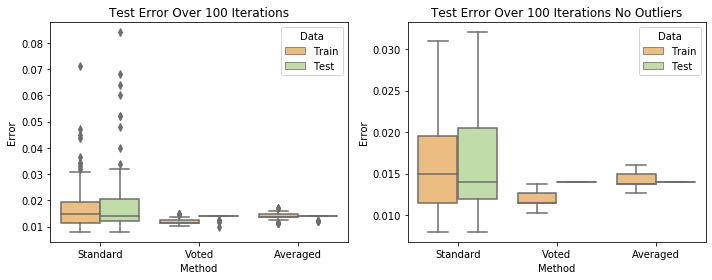

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.boxplot(data=results, x='Method', y='Error', hue='Data', palette='Spectral', showfliers=True, ax=ax[0])
sns.boxplot(data=results, x='Method', y='Error', hue='Data', palette='Spectral', showfliers=False, ax=ax[1])
ax[0].set_title(f'Test Error Over {iterations} Iterations')
ax[1].set_title(f'Test Error Over {iterations} Iterations No Outliers')
fig.tight_layout()
plt.show()